In [1]:
%%html
<style>
.output_subarea.output_text.output_stream.output_stdout > pre {
  width:max-content;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output > pre {
  width:max-content;
    
    
</style>

In [2]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("""<style>.container {width:95% !important} pre{font-size: 10px;}</style>"""))

In [ ]:
# !pip install optuna
# !pip install category_encoders

In [3]:
import optuna
from xgboost.sklearn import XGBClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import brier_score_loss, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
import pickle

import warnings
warnings.filterwarnings("ignore")

In [187]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy import stats as st
import category_encoders as ce
#----------------------CategoricalTransformer----------------------

class CategoricalTransformer():
    def __init__(self, max_unique_values = 20):
        self.max_unique_values = max_unique_values
        self.__selected_features = None

    def fit(self, X):
        # Identify features with 20 or fewer unique values
        self.__selected_features = X.columns[X.nunique() <= self.max_unique_values]
        return self

    def transform(self, X):
        X_transformed = X.copy()
        # Convert selected features to categorical
        X_transformed[self.__selected_features] = X_transformed[self.__selected_features].astype('object')
        return X_transformed
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)



#----------------------MissingValuesFiller----------------------

class MissingValuesFiller():
    def __init__(self, numeric_strategy='mean', categorical_strategy='most_frequent'):
        self.numeric_strategy = numeric_strategy
        self.categorical_strategy = categorical_strategy
        self.__numeric_cols = None
        self.__categorical_cols = None
        self.__mean_numeric_series = None
        self.__mode_categorical_series = None

    def fit(self, X):
        # Separate numeric and categorical columns
        self.__numeric_cols = X.select_dtypes(include='number').columns
        self.__categorical_cols = X.select_dtypes(include='object').columns
        self.__mean_numeric_series= X[self.__numeric_cols].agg(self.numeric_strategy)
        self.__mode_categorical_series= X[self.__categorical_cols].mode().iloc[0] if self.categorical_strategy  == 'most_frequent' else self.categorical_strategy

    def transform(self, X):
        X_transformed = X.copy()
         # Fill missing values in numeric columns
        X_transformed[self.__numeric_cols] = X[self.__numeric_cols].fillna(self.__mean_numeric_series)

        # Fill missing values in categorical columns
        X_transformed[self.__categorical_cols] = X[self.__categorical_cols].fillna(self.__mode_categorical_series)

        return X_transformed

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)



#----------------------DropHighCorrelationFeatures----------------------


class DropHighCorrelationFeatures():
    def __init__(self, threshold = 0.85):
        self.threshold = threshold
        self.to_drop_cols = None

    def fit(self, X):
        # Calculate the correlation matrix
        correlation_matrix = X.corr().abs()

        # Create a mask to identify highly correlated features
        upper_triangle_mask = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

        # Identify features with correlation above the threshold
        to_drop = [column for column in upper_triangle_mask.columns if any(upper_triangle_mask[column] > self.threshold)]

        self.to_drop_cols = to_drop



    def transform(self, X):
        X_transformed = X.copy()

        # Drop highly correlated features
        X_transformed = X_transformed.drop(columns=self.to_drop_cols)

        return X_transformed
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

#----------------------SplitterByType----------------------

class SplitterByType():
    def __init__(self):
        self.__numeric_cols = None
        self.__categorical_cols = None

    def fit(self, X):
        # Identify numeric and categorical columns
        self.__numeric_cols = X.select_dtypes(include='number').columns
        self.__categorical_cols = X.select_dtypes(include='object').columns



    def transform(self, X):
        X_transformed = X.copy()

        # Create DataFrames based on column types
        numeric_df = X[self.__numeric_cols].copy()
        categorical_df = X[self.__categorical_cols].copy()

        return numeric_df, categorical_df

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


#----------------------ConstantsAndHighCardinalityDropper----------------------
class ConstantsAndHighCardinalityDropper():
    def __init__(self,max_unique_values=2000):
        self.max_unique_values = max_unique_values
        self.__non_constant_cols = None
        self.__high_cardinality_cols = None

    def fit(self, X):
        # Identify numeric and categorical columns
        self.__non_constant_cols = X.columns[X.nunique() > 1]
        self.__high_cardinality_cols = X.columns[X.nunique() > self.max_unique_values]


    def transform(self, X):
        X_transformed = X.copy()

        # Get non constants columns
        X_transformed = X_transformed[self.__non_constant_cols]

        #drop high cardinality columns
        X_transformed = X_transformed.drop(columns=self.__high_cardinality_cols)

        return X_transformed

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


#----------------------ConstantsAndHighCardinalityDropper----------------------
class FrequencyEncoder():
    def __init__(self):
        self.categorical_features = None
        #dictionary with values of the categorical features as keys and dictionary of frequencies
        self.mapper = {}

    def fit(self, X):
        # Identify numeric and categorical columns
        self.categorical_features = X.select_dtypes('object').columns

        for cat_col in self.categorical_features:
            class_values_frequency = {}
            for class_value in X[cat_col].unique():
                class_values_frequency[class_value] = sum(X[cat_col]==class_value)/X.shape[0]
            self.mapper[cat_col] = class_values_frequency


    def transform(self, X):
        X_transformed = X.copy()

        # apply frequencies mapping
        for cat_col in self.categorical_features:
            X_transformed[cat_col] = X_transformed[cat_col].map(self.mapper[cat_col])

        return X_transformed

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [6]:
df = pd.read_csv('../data/raw/training.csv')
X = df.iloc[:, :-1].copy()
y = df.Target
X_val1 = pd.read_csv('../data/raw/data_validation3.csv')

# Example

In [188]:
def preprocess_data(X: pd.DataFrame, X_val: pd.DataFrame, numeric_strategy='mean',categorical_strategy='most_frequent',
                   threshold=0.85,cat_transformer_max_unique_values = 20,cardinality_max_unique_values=2000,
                   n_components = 40, cat_encoder_strategy = 'woee'):
    # Step 0: Copy Values to transform
    X_transformed = X.copy()
    X_val_transformed = X_val.copy()

    # Step 1: Fill missing values
    filler = MissingValuesFiller(numeric_strategy=numeric_strategy, categorical_strategy=categorical_strategy)
    X_transformed = filler.fit_transform(X_transformed)
    X_val_transformed = filler.transform(X_val_transformed)

    # Step 2: Reduce dimensionality due to high correlation
    correlation_reducer = DropHighCorrelationFeatures(threshold=threshold)
    X_transformed = correlation_reducer.fit_transform(X_transformed)
    X_val_transformed = correlation_reducer.transform(X_val_transformed)

    # Step 3: Convert features to categorical
    categorical_transformer = CategoricalTransformer(max_unique_values = cat_transformer_max_unique_values).fit(X_transformed)
    X_transformed = categorical_transformer.transform(X_transformed)
    X_val_transformed = categorical_transformer.transform(X_val_transformed)


    # Step 4: Drop constants and high-cardinality features
    dropper = ConstantsAndHighCardinalityDropper(max_unique_values = cardinality_max_unique_values)
    X_transformed = dropper.fit_transform(X_transformed)
    X_val_transformed = dropper.transform(X_val_transformed)


    # Step 5: Split the DataFrame into numeric and categorical parts
    splitter = SplitterByType()
    X_transformed_numeric, X_transformed_categorical = splitter.fit_transform(X_transformed)
    X_val_transformed_numeric, X_val_transformed_categorical = splitter.transform(X_val_transformed)
    incosistencias_columns = ['Feature_11', 'Feature_71', 'Feature_88', 'Feature_90',
       'Feature_143', 'Feature_156', 'Feature_176', 'Feature_194',
       'Feature_200', 'Feature_216', 'Feature_237', 'Feature_268',
       'Feature_273', 'Feature_319', 'Feature_339', 'Feature_386',
       'Feature_391', 'Feature_402', 'Feature_407', 'Feature_410',
       'Feature_417', 'Feature_421', 'Feature_422', 'Feature_427',
       'Feature_431', 'Feature_441', 'Feature_471', 'Feature_477',
       'Feature_492', 'Feature_532']
    col_new = set(X_transformed_numeric)-set(incosistencias_columns)
    X_transformed_numeric = X_transformed_numeric[col_new]
    X_val_transformed_numeric = X_val_transformed_numeric[col_new]

    # Step 6: Reduce dimensionality of numeric features
    pca = PCA(n_components)
#     X_transformed_numeric = pd.DataFrame(pca.fit_transform(X_transformed_numeric))
#     X_val_transformed_numeric = pd.DataFrame(pca.transform(X_val_transformed_numeric))
#     print(f'Explained Variance with {n_components} components: {pca.explained_variance_ratio_.sum()}')

    # Step 7: Categorical Encoding
    if cat_encoder_strategy == 'woee':
        # Step 7.1 (Optional): Apply WOE Encoding
        X_columns = X_transformed_categorical.columns
        woe_encoder = ce.WOEEncoder(cols=X_columns)

        X_transformed_categorical = woe_encoder.fit_transform(X_transformed_categorical, y)
        X_val_transformed_categorical = woe_encoder.transform(X_val_transformed_categorical)
    elif cat_encoder_strategy == 'freq':
        # Step 7.2 (Optional): Apply self defined Frequency Encoding
        X_columns = X_transformed_categorical.columns
        freq_encoder = FrequencyEncoder()

        X_transformed_categorical = freq_encoder.fit_transform(X_transformed_categorical)
        X_val_transformed_categorical = freq_encoder.transform(X_val_transformed_categorical)
    else:
        # Step 7.3 (Optional): Apply One Hot Encoding
        X_columns = X_transformed_categorical.columns
        ohe_encoder = ce.OneHotEncoder()

        X_transformed_categorical = ohe_encoder.fit_transform(X_transformed_categorical)
        X_val_transformed_categorical = ohe_encoder.transform(X_val_transformed_categorical)

    # Step 8: Mixing steps 6 & 7 to prepare data for modelling
    X_transformed = pd.concat([X_transformed_numeric,X_transformed_categorical], axis=1)
    X_val_transformed = pd.concat([X_val_transformed_numeric,X_val_transformed_categorical], axis=1)

    return X_transformed, X_val_transformed

**Next steps... concatenate dataframes applying encoders to categorical data**

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)

In [190]:
# X_transformed, X_val_transformed = preprocess_data(X, X_val1, cat_encoder_strategy='ohe')
X_transformed, X_val_transformed = preprocess_data(X_train, X_test, cat_encoder_strategy='freq')

In [139]:
X_train = X_transformed
X_test = X_val_transformed

# Modelling

In [60]:
# from sklearn.metrics import classification_report, brier_score_loss, confusion_matrix, accuracy_score


# # Create a function that return the metrics we need to compare if the model is a good one.
# # The function returns 'brier_score', 'confusion matrix', 'accuracy negative and positive', 'accuracy'
# def metricas_modelo(y_real, prob_pred):
#     y_pred = list(map(lambda x: 1 if x==True else 0, prob_pred>0.5))
#     brier = round(brier_score_loss(y_real,prob_pred)*100,2)
#     cm = confusion_matrix(y_real,y_pred)
#     acc_neg = round(100*cm[0,0]/(cm[0,0]+cm[0,1]),2)
#     acc_pos = round(100*cm[1,1]/(cm[1,0]+cm[1,1]),2)
#     acc = round(100*accuracy_score(y_real, y_pred),2)
#     print(f' brier: {brier},\n confusion_m: \n{cm},\n acc_neg: {acc_neg},\n acc_pos: {acc_pos},\n accuracy: {acc}')

Usando metodología WOEE

In [46]:
# # Crear un objeto DMatrix para los datos de entrenamiento y prueba
# dtrain = xgb.DMatrix(X_train, label=y_train)
# dtest = xgb.DMatrix(X_test, label=y_test)

# # Definir los parámetros del modelo
# params = {
#     'objective': 'binary:logistic',
#     'max_depth': 3,
#     'learning_rate': 0.05,
#     'eval_metric': 'logloss'
# }

# # Entrenar el modelo
# num_rounds = 100
# model = xgb.train(params, dtrain, num_rounds)

# # Realizar predicciones en el conjunto de prueba
# y_pred = model.predict(dtest)


# metricas_modelo(y_test,y_pred)

In [31]:
# ?train_test_split

In [32]:
# X_transformed

In [33]:
# # Dividir los datos en conjuntos de entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.90, random_state=42, stratify=y)



In [161]:
# Define la función objetivo para la optimización de hiperparámetros
def objective(trial):
    # Define los hiperparámetros que se optimizarán
    param = {
        "verbose": 1,
        "seed":19970808,
        "objective":"binary:logistic",
        "learning_rate":trial.suggest_float("learning_rate", .15, .40, log=True),
        "n_estimators": trial.suggest_categorical("n_estimators", [100,150, 200, 300]),
        "max_depth": trial.suggest_int("max_depth", 1, 5),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)
    }
    
    # Crea un modelo de regresión logística con los hiperparámetros definidos
    xgb_model = XGBClassifier(**param)
    steps = [('over', SMOTE(sampling_strategy='minority', random_state=42)), ('model', xgb_model)]
    steps = [('model', xgb_model)]
    pipeline = Pipeline(steps=steps)
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict_proba(X_test)[:,-1]
    brier_score = brier_score_loss(y_test, predictions)
    if brier_score<0.080:
        print("../models/freq_3_{}.pickle".format(trial.number))
        with open("../models/freq_3_{}.pickle".format(trial.number), "wb") as fout:
             pickle.dump(pipeline, fout)
    return brier_score

In [163]:
# Crea un objeto de estudio de Optuna para la optimización
study = optuna.create_study(direction="minimize")

# Realiza la optimización de hiperparámetros con un número limitado de iteraciones y tiempo máximo
study.optimize(objective, n_trials=1000,
    timeout=600,
    show_progress_bar=False)

# Imprime información sobre los resultados de la optimización
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-12-17 22:17:00,245] A new study created in memory with name: no-name-cada3fe7-7b53-4c2e-ab21-fe96718fc746
[I 2023-12-17 22:17:01,276] Trial 0 finished with value: 0.10765607588378831 and parameters: {'learning_rate': 0.17589539473098592, 'n_estimators': 300, 'max_depth': 4, 'lambda': 1.0965249185779118e-05, 'alpha': 0.013571766202540313, 'subsample': 0.7279321630926474, 'colsample_bytree': 0.8681618933457951}. Best is trial 0 with value: 0.10765607588378831.
[I 2023-12-17 22:17:02,273] Trial 1 finished with value: 0.1180186423363172 and parameters: {'learning_rate': 0.20249424497387072, 'n_estimators': 300, 'max_depth': 4, 'lambda': 0.08189955624509343, 'alpha': 1.0930604996231245e-08, 'subsample': 0.3084120094537741, 'colsample_bytree': 0.8031853881341712}. Best is trial 0 with value: 0.10765607588378831.
[I 2023-12-17 22:17:02,665] Trial 2 finished with value: 0.08802863521399734 and parameters: {'learning_rate': 0.1592016345983133, 'n_estimators': 200, 'max_depth': 1, 'lambd

[I 2023-12-17 22:17:10,911] Trial 23 finished with value: 0.09232026162514001 and parameters: {'learning_rate': 0.39579006778020825, 'n_estimators': 100, 'max_depth': 1, 'lambda': 1.759968187220077e-06, 'alpha': 0.0016957448438348031, 'subsample': 0.6898000645794831, 'colsample_bytree': 0.7659860591959895}. Best is trial 2 with value: 0.08802863521399734.
[I 2023-12-17 22:17:11,200] Trial 24 finished with value: 0.09034163076982338 and parameters: {'learning_rate': 0.3230215090171479, 'n_estimators': 100, 'max_depth': 2, 'lambda': 8.764331191393976e-06, 'alpha': 3.844080162261241e-06, 'subsample': 0.9004984079186802, 'colsample_bytree': 0.7426606172725744}. Best is trial 2 with value: 0.08802863521399734.
[I 2023-12-17 22:17:11,447] Trial 25 finished with value: 0.09298617519537616 and parameters: {'learning_rate': 0.3578710167709621, 'n_estimators': 100, 'max_depth': 1, 'lambda': 2.4949201168998354e-07, 'alpha': 0.0008547531597259292, 'subsample': 0.6630734334670597, 'colsample_bytree

[I 2023-12-17 22:17:20,747] Trial 46 finished with value: 0.09204934164710254 and parameters: {'learning_rate': 0.33238915957419424, 'n_estimators': 200, 'max_depth': 2, 'lambda': 4.492879197149442e-05, 'alpha': 0.00019784033572144477, 'subsample': 0.7529818115051653, 'colsample_bytree': 0.6865571994562282}. Best is trial 41 with value: 0.08678797719353104.
[I 2023-12-17 22:17:20,995] Trial 47 finished with value: 0.08453433903463858 and parameters: {'learning_rate': 0.36299749686945126, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.021659443100312106, 'alpha': 0.006546646361476968, 'subsample': 0.6017972352837427, 'colsample_bytree': 0.7607749359767453}. Best is trial 47 with value: 0.08453433903463858.
[I 2023-12-17 22:17:21,476] Trial 48 finished with value: 0.1361350314399146 and parameters: {'learning_rate': 0.3632271139875163, 'n_estimators': 100, 'max_depth': 5, 'lambda': 0.0121522965701664, 'alpha': 0.007967997120615768, 'subsample': 0.26882009329514084, 'colsample_bytree': 

[I 2023-12-17 22:17:27,968] Trial 69 finished with value: 0.0873668948554481 and parameters: {'learning_rate': 0.20503745069119442, 'n_estimators': 100, 'max_depth': 1, 'lambda': 3.789362729528142e-07, 'alpha': 0.0022067291029795014, 'subsample': 0.814115249900661, 'colsample_bytree': 0.7116589049727283}. Best is trial 47 with value: 0.08453433903463858.
[I 2023-12-17 22:17:28,228] Trial 70 finished with value: 0.08869612835256802 and parameters: {'learning_rate': 0.20711151290099944, 'n_estimators': 100, 'max_depth': 1, 'lambda': 4.627641796970795e-08, 'alpha': 0.0027335188553831036, 'subsample': 0.8273424484621307, 'colsample_bytree': 0.6988544949599172}. Best is trial 47 with value: 0.08453433903463858.
[I 2023-12-17 22:17:28,489] Trial 71 finished with value: 0.08757725041893666 and parameters: {'learning_rate': 0.1827637052329233, 'n_estimators': 100, 'max_depth': 1, 'lambda': 4.4633576536102847e-07, 'alpha': 0.030451754414042822, 'subsample': 0.7335365436003147, 'colsample_bytree

[I 2023-12-17 22:17:34,583] Trial 92 finished with value: 0.08878363336536074 and parameters: {'learning_rate': 0.21414716033409834, 'n_estimators': 100, 'max_depth': 1, 'lambda': 1.1135951578325126e-08, 'alpha': 0.13013594894572642, 'subsample': 0.8373539265923596, 'colsample_bytree': 0.7294456446401165}. Best is trial 47 with value: 0.08453433903463858.
[I 2023-12-17 22:17:34,841] Trial 93 finished with value: 0.08658919189062322 and parameters: {'learning_rate': 0.225234448763907, 'n_estimators': 100, 'max_depth': 1, 'lambda': 4.801782947335516e-08, 'alpha': 0.05949253126282674, 'subsample': 0.807207169851884, 'colsample_bytree': 0.767221933589979}. Best is trial 47 with value: 0.08453433903463858.
[I 2023-12-17 22:17:35,100] Trial 94 finished with value: 0.08547987585219784 and parameters: {'learning_rate': 0.23975674005515804, 'n_estimators': 100, 'max_depth': 1, 'lambda': 4.334563660875145e-08, 'alpha': 0.05104207619836699, 'subsample': 0.8029426776167832, 'colsample_bytree': 0.7

[I 2023-12-17 22:17:41,334] Trial 115 finished with value: 0.08721351887863504 and parameters: {'learning_rate': 0.24076886314038035, 'n_estimators': 100, 'max_depth': 1, 'lambda': 2.5098800387252225e-08, 'alpha': 0.035567272412324775, 'subsample': 0.779006880778663, 'colsample_bytree': 0.7750032304695057}. Best is trial 47 with value: 0.08453433903463858.
[I 2023-12-17 22:17:41,590] Trial 116 finished with value: 0.08743346975156234 and parameters: {'learning_rate': 0.21493847420729173, 'n_estimators': 100, 'max_depth': 1, 'lambda': 9.674649876670546e-08, 'alpha': 0.08281747390616404, 'subsample': 0.7005557512518326, 'colsample_bytree': 0.7225034798188451}. Best is trial 47 with value: 0.08453433903463858.
[I 2023-12-17 22:17:41,852] Trial 117 finished with value: 0.087103730145772 and parameters: {'learning_rate': 0.22292759631691583, 'n_estimators': 100, 'max_depth': 1, 'lambda': 6.11895359305812e-08, 'alpha': 0.18784214789325207, 'subsample': 0.7254837494972737, 'colsample_bytree':

[I 2023-12-17 22:17:48,070] Trial 138 finished with value: 0.08683053450910437 and parameters: {'learning_rate': 0.2665162026799368, 'n_estimators': 100, 'max_depth': 1, 'lambda': 5.178379693049053e-08, 'alpha': 0.06364275317022851, 'subsample': 0.7760087898114821, 'colsample_bytree': 0.7464301645747262}. Best is trial 47 with value: 0.08453433903463858.
[I 2023-12-17 22:17:48,347] Trial 139 finished with value: 0.0868973011092947 and parameters: {'learning_rate': 0.18045309824501282, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.00020557182054694844, 'alpha': 0.25181358472118737, 'subsample': 0.7450795369237333, 'colsample_bytree': 0.7943982650751349}. Best is trial 47 with value: 0.08453433903463858.
[I 2023-12-17 22:17:48,808] Trial 140 finished with value: 0.08707241155859168 and parameters: {'learning_rate': 0.2050634875955622, 'n_estimators': 200, 'max_depth': 1, 'lambda': 2.3128127940067203e-08, 'alpha': 0.7516391093463033, 'subsample': 0.8347542510672485, 'colsample_bytree':

[I 2023-12-17 22:17:55,236] Trial 161 finished with value: 0.088662128390421 and parameters: {'learning_rate': 0.33666059750229205, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.019708336702097762, 'alpha': 0.882854450778986, 'subsample': 0.7254646462354624, 'colsample_bytree': 0.6974754782394769}. Best is trial 47 with value: 0.08453433903463858.
[I 2023-12-17 22:17:55,494] Trial 162 finished with value: 0.08991651065851632 and parameters: {'learning_rate': 0.22555727881907822, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.11046834397752939, 'alpha': 0.6295690871193548, 'subsample': 0.6944610012262002, 'colsample_bytree': 0.6734035442158555}. Best is trial 47 with value: 0.08453433903463858.
[I 2023-12-17 22:17:55,754] Trial 163 finished with value: 0.09011050124275292 and parameters: {'learning_rate': 0.22117015802665133, 'n_estimators': 100, 'max_depth': 1, 'lambda': 1.3934601858375647e-07, 'alpha': 0.36891580161291276, 'subsample': 0.7091246499316033, 'colsample_bytree': 0.67

[I 2023-12-17 22:18:02,230] Trial 184 finished with value: 0.08785346807255945 and parameters: {'learning_rate': 0.29378576257392525, 'n_estimators': 150, 'max_depth': 1, 'lambda': 0.00016479581506019788, 'alpha': 0.09453370035354983, 'subsample': 0.8086865933766624, 'colsample_bytree': 0.654721358593527}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:18:02,608] Trial 185 finished with value: 0.08830823318537519 and parameters: {'learning_rate': 0.28506813175728846, 'n_estimators': 150, 'max_depth': 1, 'lambda': 7.518316403686324e-05, 'alpha': 0.038557081373967114, 'subsample': 0.7845314270251904, 'colsample_bytree': 0.6074340685444496}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:18:02,994] Trial 186 finished with value: 0.08771908640096825 and parameters: {'learning_rate': 0.2976972882862347, 'n_estimators': 150, 'max_depth': 1, 'lambda': 0.00010865135721483542, 'alpha': 0.06803483832915601, 'subsample': 0.8246381863382581, 'colsample_byt

[I 2023-12-17 22:18:09,997] Trial 207 finished with value: 0.09438328456779818 and parameters: {'learning_rate': 0.26843874029678966, 'n_estimators': 100, 'max_depth': 1, 'lambda': 7.921964493275934e-05, 'alpha': 0.09524775327386531, 'subsample': 0.7305055362144665, 'colsample_bytree': 0.6813729841546956}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:18:10,263] Trial 208 finished with value: 0.08845003682360447 and parameters: {'learning_rate': 0.28142723376248846, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.00013452567726008965, 'alpha': 0.14367474230556243, 'subsample': 0.7995796915164204, 'colsample_bytree': 0.6533984403245271}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:18:10,525] Trial 209 finished with value: 0.08597656171492943 and parameters: {'learning_rate': 0.2587535019087818, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.000550263948624226, 'alpha': 1.2951570637721892e-07, 'subsample': 0.7609160791001458, 'colsample_by

[I 2023-12-17 22:18:16,441] Trial 230 finished with value: 0.09064830911296147 and parameters: {'learning_rate': 0.2529595888594895, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.03601974349441412, 'alpha': 1.6317977338365297e-06, 'subsample': 0.7209588078416528, 'colsample_bytree': 0.6587761157564054}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:18:16,720] Trial 231 finished with value: 0.08455533540904601 and parameters: {'learning_rate': 0.2674218832295062, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.04801037667547357, 'alpha': 1.000866293215044e-05, 'subsample': 0.7736327734366768, 'colsample_bytree': 0.6775989698930291}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:18:16,992] Trial 232 finished with value: 0.08737018685076361 and parameters: {'learning_rate': 0.2669404135322244, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.05470753038293549, 'alpha': 6.260438670289356e-06, 'subsample': 0.7672586764778035, 'colsample_bytree

[I 2023-12-17 22:18:23,416] Trial 253 finished with value: 0.09513501967355993 and parameters: {'learning_rate': 0.2499044662348552, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.00014019093893011332, 'alpha': 2.766304589119728e-06, 'subsample': 0.23446417112305623, 'colsample_bytree': 0.6571476527987309}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:18:23,679] Trial 254 finished with value: 0.09165723704821126 and parameters: {'learning_rate': 0.25690367599631786, 'n_estimators': 100, 'max_depth': 1, 'lambda': 3.268148953177976e-05, 'alpha': 1.2204628053983484e-06, 'subsample': 0.738633208486026, 'colsample_bytree': 0.6681670459588097}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:18:23,943] Trial 255 finished with value: 0.08703498636654948 and parameters: {'learning_rate': 0.2416024687944126, 'n_estimators': 100, 'max_depth': 1, 'lambda': 8.004247676629288e-05, 'alpha': 6.781399941176602e-07, 'subsample': 0.7707636290407542, 'colsampl

[I 2023-12-17 22:18:30,156] Trial 276 finished with value: 0.08718594173250571 and parameters: {'learning_rate': 0.29098497775615645, 'n_estimators': 100, 'max_depth': 1, 'lambda': 1.535844886798573e-05, 'alpha': 9.505585779523975e-08, 'subsample': 0.7953219517949761, 'colsample_bytree': 0.6541118193804419}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:18:30,423] Trial 277 finished with value: 0.08643527329100935 and parameters: {'learning_rate': 0.2577797521511181, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.04212818513748576, 'alpha': 2.151051152957147e-05, 'subsample': 0.7620953490767518, 'colsample_bytree': 0.6471745889951318}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:18:30,740] Trial 278 finished with value: 0.08823891792125876 and parameters: {'learning_rate': 0.2875127683842617, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.0002748104661821854, 'alpha': 4.409537772849964e-06, 'subsample': 0.744131687926747, 'colsample_byt

[I 2023-12-17 22:18:37,407] Trial 299 finished with value: 0.08673745540183465 and parameters: {'learning_rate': 0.29157666100619284, 'n_estimators': 100, 'max_depth': 1, 'lambda': 1.932489756661826e-05, 'alpha': 0.13985363285016617, 'subsample': 0.7858090527685937, 'colsample_bytree': 0.7840909434201395}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:18:37,688] Trial 300 finished with value: 0.10366414805376911 and parameters: {'learning_rate': 0.38592154073414786, 'n_estimators': 100, 'max_depth': 1, 'lambda': 5.859265448828145e-05, 'alpha': 0.9885341445530251, 'subsample': 0.31491228963787693, 'colsample_bytree': 0.6609239172580558}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:18:37,953] Trial 301 finished with value: 0.09012815478950427 and parameters: {'learning_rate': 0.2862308263580436, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.00013404224927660014, 'alpha': 0.0037398206944328693, 'subsample': 0.7354151530517986, 'colsample_by

[I 2023-12-17 22:18:44,619] Trial 322 finished with value: 0.08653985517719248 and parameters: {'learning_rate': 0.28152810826078817, 'n_estimators': 100, 'max_depth': 1, 'lambda': 9.486995054587349e-06, 'alpha': 1.522189788459224e-07, 'subsample': 0.5929463427606092, 'colsample_bytree': 0.6815848380797354}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:18:44,892] Trial 323 finished with value: 0.09096337111772453 and parameters: {'learning_rate': 0.2751121987630709, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.0005044997863663454, 'alpha': 4.180391146464504e-07, 'subsample': 0.5814555205695346, 'colsample_bytree': 0.6930850416457098}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:18:45,174] Trial 324 finished with value: 0.0894488492618666 and parameters: {'learning_rate': 0.26107990204528075, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.01888738398428009, 'alpha': 2.83540992070933e-07, 'subsample': 0.5607750175082298, 'colsample_byt

[I 2023-12-17 22:18:51,659] Trial 345 finished with value: 0.08925123578848591 and parameters: {'learning_rate': 0.2520784018278044, 'n_estimators': 100, 'max_depth': 1, 'lambda': 1.2079652498992411e-05, 'alpha': 4.744422536941028e-07, 'subsample': 0.5798932881122147, 'colsample_bytree': 0.6881806205569584}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:18:51,975] Trial 346 finished with value: 0.09009203234263169 and parameters: {'learning_rate': 0.27784721648676053, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.03170296725038878, 'alpha': 2.060533432785719e-06, 'subsample': 0.7371000427417459, 'colsample_bytree': 0.6732804018878297}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:18:52,240] Trial 347 finished with value: 0.08844549983358788 and parameters: {'learning_rate': 0.32293844491692536, 'n_estimators': 100, 'max_depth': 1, 'lambda': 3.917898426281764e-06, 'alpha': 5.767205730651938e-08, 'subsample': 0.5503465811179789, 'colsample_

[I 2023-12-17 22:18:58,765] Trial 368 finished with value: 0.08684790374715012 and parameters: {'learning_rate': 0.28156377446743713, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.008206304610510261, 'alpha': 0.3871948489564288, 'subsample': 0.5929394134469926, 'colsample_bytree': 0.6978414959237916}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:18:59,064] Trial 369 finished with value: 0.08914981566243445 and parameters: {'learning_rate': 0.28596156584298377, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.018132128298083323, 'alpha': 0.7981243270982226, 'subsample': 0.5687716677287898, 'colsample_bytree': 0.7169471333858487}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:18:59,349] Trial 370 finished with value: 0.09201953764784518 and parameters: {'learning_rate': 0.3027544205106916, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.020660206293805147, 'alpha': 0.2030236232679766, 'subsample': 0.590904494682524, 'colsample_bytree': 0.6

[I 2023-12-17 22:19:06,458] Trial 391 finished with value: 0.09044418352525431 and parameters: {'learning_rate': 0.3816342857620241, 'n_estimators': 100, 'max_depth': 1, 'lambda': 5.419172865008238e-05, 'alpha': 9.643122206924711e-08, 'subsample': 0.60156243543683, 'colsample_bytree': 0.6580388803671438}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:19:06,845] Trial 392 finished with value: 0.09279224929243549 and parameters: {'learning_rate': 0.25344006783875883, 'n_estimators': 100, 'max_depth': 2, 'lambda': 9.68758187277333e-05, 'alpha': 0.13759799329792072, 'subsample': 0.7617747713126841, 'colsample_bytree': 0.6850276944787845}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:19:07,173] Trial 393 finished with value: 0.08570909902646752 and parameters: {'learning_rate': 0.2671870172487941, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.348251937010839, 'alpha': 0.6140222503216641, 'subsample': 0.8037818256651976, 'colsample_bytree': 0.6

[I 2023-12-17 22:19:14,355] Trial 414 finished with value: 0.08768500974280194 and parameters: {'learning_rate': 0.3358754075329182, 'n_estimators': 100, 'max_depth': 1, 'lambda': 5.094030599519433e-07, 'alpha': 0.01766405263852142, 'subsample': 0.8013174789121852, 'colsample_bytree': 0.6562448944820639}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:19:14,656] Trial 415 finished with value: 0.0849310115068979 and parameters: {'learning_rate': 0.31387340657515655, 'n_estimators': 100, 'max_depth': 1, 'lambda': 3.866055625452927e-07, 'alpha': 0.009694377827542231, 'subsample': 0.7819396665600858, 'colsample_bytree': 0.6733429179982079}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:19:14,968] Trial 416 finished with value: 0.08462171769302514 and parameters: {'learning_rate': 0.31239250607471886, 'n_estimators': 100, 'max_depth': 1, 'lambda': 8.855989255608216e-07, 'alpha': 0.011760587411308704, 'subsample': 0.7839754170608431, 'colsample_bytr

[I 2023-12-17 22:19:22,424] Trial 437 finished with value: 0.09038072767133286 and parameters: {'learning_rate': 0.3418787732749179, 'n_estimators': 100, 'max_depth': 1, 'lambda': 2.0538674955833464e-06, 'alpha': 0.027625938125481184, 'subsample': 0.7650240829280729, 'colsample_bytree': 0.6474914982007669}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:19:22,729] Trial 438 finished with value: 0.09143032571846446 and parameters: {'learning_rate': 0.32357081272782867, 'n_estimators': 100, 'max_depth': 1, 'lambda': 2.9115723491560745e-06, 'alpha': 0.015732289436075134, 'subsample': 0.7262806009966873, 'colsample_bytree': 0.6920523903266768}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:19:23,045] Trial 439 finished with value: 0.08689719161922564 and parameters: {'learning_rate': 0.35694172025191845, 'n_estimators': 100, 'max_depth': 1, 'lambda': 6.543915972006847e-07, 'alpha': 0.0068894443240544, 'subsample': 0.7819190067488084, 'colsample_by

[I 2023-12-17 22:19:31,639] Trial 460 finished with value: 0.0843542461931155 and parameters: {'learning_rate': 0.2903641016341779, 'n_estimators': 100, 'max_depth': 1, 'lambda': 2.895367324740077e-07, 'alpha': 0.00022002333819626097, 'subsample': 0.7810227804264624, 'colsample_bytree': 0.7020320141337718}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:19:31,966] Trial 461 finished with value: 0.08793333714223674 and parameters: {'learning_rate': 0.28939641193936677, 'n_estimators': 100, 'max_depth': 1, 'lambda': 2.1568927534703897e-07, 'alpha': 0.0013840230130651365, 'subsample': 0.8435893937589526, 'colsample_bytree': 0.7051351092384277}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:19:32,295] Trial 462 finished with value: 0.08405321793517136 and parameters: {'learning_rate': 0.3045126739742116, 'n_estimators': 100, 'max_depth': 1, 'lambda': 2.5547660630158495e-07, 'alpha': 0.00018924625580820297, 'subsample': 0.8089576726569873, 'colsamp

[I 2023-12-17 22:19:40,124] Trial 483 finished with value: 0.10309870327427015 and parameters: {'learning_rate': 0.31010255219262267, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.01568282368679223, 'alpha': 0.0008213274100939926, 'subsample': 0.20310763375889185, 'colsample_bytree': 0.6832961340712853}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:19:40,482] Trial 484 finished with value: 0.09109905314152753 and parameters: {'learning_rate': 0.2833117869968115, 'n_estimators': 100, 'max_depth': 1, 'lambda': 2.7831611130660213e-06, 'alpha': 0.00044684609365164843, 'subsample': 0.5728077470506546, 'colsample_bytree': 0.7038631947598649}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:19:40,834] Trial 485 finished with value: 0.08583057688594227 and parameters: {'learning_rate': 0.34630847278450483, 'n_estimators': 100, 'max_depth': 1, 'lambda': 8.778773801819473e-08, 'alpha': 0.00018220113271248168, 'subsample': 0.5853096735049198, 'colsamp

[I 2023-12-17 22:19:48,427] Trial 506 finished with value: 0.08909251879337182 and parameters: {'learning_rate': 0.2837134736091318, 'n_estimators': 100, 'max_depth': 1, 'lambda': 1.3041584748689042e-07, 'alpha': 0.00024002773899093713, 'subsample': 0.6076354564825356, 'colsample_bytree': 0.6888465603302976}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:19:48,952] Trial 507 finished with value: 0.09027955494350999 and parameters: {'learning_rate': 0.33472405751699286, 'n_estimators': 200, 'max_depth': 1, 'lambda': 0.012352323165595404, 'alpha': 6.267596631020016e-05, 'subsample': 0.8372449732451599, 'colsample_bytree': 0.7184377565056346}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:19:49,268] Trial 508 finished with value: 0.08641523175797826 and parameters: {'learning_rate': 0.37389004516422525, 'n_estimators': 100, 'max_depth': 1, 'lambda': 1.4383517932901636e-06, 'alpha': 2.082219183509049e-05, 'subsample': 0.7937881248943155, 'colsamp

[I 2023-12-17 22:19:57,084] Trial 529 finished with value: 0.10936096415341595 and parameters: {'learning_rate': 0.354543789263087, 'n_estimators': 100, 'max_depth': 4, 'lambda': 0.22063885833056632, 'alpha': 0.00016797349038173424, 'subsample': 0.7767590039949425, 'colsample_bytree': 0.6819924645918988}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:19:57,746] Trial 530 finished with value: 0.10307816553976691 and parameters: {'learning_rate': 0.2941407974299359, 'n_estimators': 100, 'max_depth': 5, 'lambda': 0.00042607236309721863, 'alpha': 0.0025655952003675224, 'subsample': 0.7910704470386989, 'colsample_bytree': 0.6887712686405176}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:19:58,078] Trial 531 finished with value: 0.08330070852874763 and parameters: {'learning_rate': 0.273926480912493, 'n_estimators': 100, 'max_depth': 1, 'lambda': 6.260891804633457e-07, 'alpha': 0.01883941449357513, 'subsample': 0.6235336112624392, 'colsample_bytre

[I 2023-12-17 22:20:05,689] Trial 552 finished with value: 0.0869078035707276 and parameters: {'learning_rate': 0.2728832861630181, 'n_estimators': 150, 'max_depth': 1, 'lambda': 0.0007993211898525416, 'alpha': 0.0002595519313608938, 'subsample': 0.6113586441270881, 'colsample_bytree': 0.6819659413614877}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:20:06,091] Trial 553 finished with value: 0.0910489420153601 and parameters: {'learning_rate': 0.29351587161637127, 'n_estimators': 150, 'max_depth': 1, 'lambda': 0.000287193842805176, 'alpha': 3.6083618210921094e-05, 'subsample': 0.7700578249386333, 'colsample_bytree': 0.7198839057625941}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:20:06,489] Trial 554 finished with value: 0.08948373915790005 and parameters: {'learning_rate': 0.2843807103993566, 'n_estimators': 150, 'max_depth': 1, 'lambda': 3.601391194472861e-07, 'alpha': 7.243815152381879e-06, 'subsample': 0.6569309951620205, 'colsample_by

[I 2023-12-17 22:20:14,281] Trial 575 finished with value: 0.08598892762122504 and parameters: {'learning_rate': 0.30429977022684446, 'n_estimators': 100, 'max_depth': 1, 'lambda': 1.389927097153811e-07, 'alpha': 0.038330710659599226, 'subsample': 0.8094467845529879, 'colsample_bytree': 0.6965642674334123}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:20:14,685] Trial 576 finished with value: 0.09054841585123935 and parameters: {'learning_rate': 0.33041210487360667, 'n_estimators': 150, 'max_depth': 1, 'lambda': 9.151200547339213e-08, 'alpha': 0.0035209132247319987, 'subsample': 0.7700477687285925, 'colsample_bytree': 0.6878677037076724}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:20:14,990] Trial 577 finished with value: 0.08595216679049045 and parameters: {'learning_rate': 0.29407533710901007, 'n_estimators': 100, 'max_depth': 1, 'lambda': 9.078062930512184e-07, 'alpha': 5.7940729725382e-06, 'subsample': 0.7891499689397575, 'colsample_b

[I 2023-12-17 22:20:21,912] Trial 598 finished with value: 0.08999177580579065 and parameters: {'learning_rate': 0.317896193106981, 'n_estimators': 100, 'max_depth': 1, 'lambda': 1.5615305139005222e-07, 'alpha': 1.1223374588448817e-05, 'subsample': 0.6203389175323544, 'colsample_bytree': 0.6959776335557907}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:20:22,223] Trial 599 finished with value: 0.0878814905970977 and parameters: {'learning_rate': 0.2996563741890206, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.14923944364363284, 'alpha': 7.774043413728135e-06, 'subsample': 0.6072658539606831, 'colsample_bytree': 0.6473332210998428}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:20:22,644] Trial 600 finished with value: 0.09871047619299766 and parameters: {'learning_rate': 0.2923785588187769, 'n_estimators': 100, 'max_depth': 3, 'lambda': 0.3452866594580613, 'alpha': 1.96068809265217e-05, 'subsample': 0.6500497142926878, 'colsample_bytree'

[I 2023-12-17 22:20:29,725] Trial 621 finished with value: 0.09837752271008933 and parameters: {'learning_rate': 0.30057306484740465, 'n_estimators': 300, 'max_depth': 1, 'lambda': 5.138074540849401e-08, 'alpha': 0.002114599745050531, 'subsample': 0.6275947547773668, 'colsample_bytree': 0.6749984355860361}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:20:30,012] Trial 622 finished with value: 0.08584131767842736 and parameters: {'learning_rate': 0.2604190820260998, 'n_estimators': 100, 'max_depth': 1, 'lambda': 4.749345722738866e-07, 'alpha': 8.898099690556142e-06, 'subsample': 0.7940790574274021, 'colsample_bytree': 0.6572174629177975}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:20:30,300] Trial 623 finished with value: 0.0876489919434913 and parameters: {'learning_rate': 0.30875850424182005, 'n_estimators': 100, 'max_depth': 1, 'lambda': 1.9884453836374834e-07, 'alpha': 0.008380688924641996, 'subsample': 0.7698773198140142, 'colsample_b

[I 2023-12-17 22:20:37,075] Trial 644 finished with value: 0.08732454332844568 and parameters: {'learning_rate': 0.27377871996976844, 'n_estimators': 100, 'max_depth': 1, 'lambda': 2.457131640561814e-07, 'alpha': 0.2864210019326059, 'subsample': 0.7175876329941416, 'colsample_bytree': 0.7372045613747575}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:20:37,725] Trial 645 finished with value: 0.09287360972870029 and parameters: {'learning_rate': 0.3300033840503623, 'n_estimators': 300, 'max_depth': 1, 'lambda': 0.07305978271322283, 'alpha': 1.9823375605658016e-05, 'subsample': 0.7792569864807687, 'colsample_bytree': 0.6487201285397121}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:20:38,016] Trial 646 finished with value: 0.09101313624918658 and parameters: {'learning_rate': 0.28442224673933825, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.0032675995880258523, 'alpha': 0.018908432042927553, 'subsample': 0.626426027350598, 'colsample_bytre

[I 2023-12-17 22:20:45,317] Trial 667 finished with value: 0.09405904018001288 and parameters: {'learning_rate': 0.2700449200957534, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.004683631364554754, 'alpha': 5.076069010778901e-06, 'subsample': 0.5641881977335744, 'colsample_bytree': 0.7166941256987354}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:20:45,613] Trial 668 finished with value: 0.08574515343619987 and parameters: {'learning_rate': 0.2925589329880578, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.00011635903603719595, 'alpha': 2.2220423356919497e-06, 'subsample': 0.6376213729598972, 'colsample_bytree': 0.6401842040792033}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:20:46,674] Trial 669 finished with value: 0.10623738464772939 and parameters: {'learning_rate': 0.28514240305785266, 'n_estimators': 300, 'max_depth': 4, 'lambda': 0.0015472698771820544, 'alpha': 0.00016753804557918732, 'subsample': 0.8046789222280883, 'colsampl

[I 2023-12-17 22:20:53,136] Trial 690 finished with value: 0.08728109490494727 and parameters: {'learning_rate': 0.27838530565669406, 'n_estimators': 100, 'max_depth': 1, 'lambda': 5.2863462231155334e-05, 'alpha': 0.00012631819381732495, 'subsample': 0.8172630740452129, 'colsample_bytree': 0.8431836381850918}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:20:53,403] Trial 691 finished with value: 0.08813610364228973 and parameters: {'learning_rate': 0.29052472749725167, 'n_estimators': 100, 'max_depth': 1, 'lambda': 1.0451049719742028e-05, 'alpha': 7.159883199915416e-05, 'subsample': 0.687578105615271, 'colsample_bytree': 0.6628155193034734}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:20:53,687] Trial 692 finished with value: 0.09011161079708921 and parameters: {'learning_rate': 0.2872639049731583, 'n_estimators': 100, 'max_depth': 1, 'lambda': 9.354843965767895e-08, 'alpha': 2.1245944800690758e-05, 'subsample': 0.7241464374880899, 'colsam

[I 2023-12-17 22:21:00,864] Trial 713 finished with value: 0.08928752615327404 and parameters: {'learning_rate': 0.26807295167762935, 'n_estimators': 150, 'max_depth': 1, 'lambda': 5.669593159015015e-05, 'alpha': 0.1097153406778731, 'subsample': 0.81302467737371, 'colsample_bytree': 0.6809940428954824}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:21:01,276] Trial 714 finished with value: 0.09984250841241869 and parameters: {'learning_rate': 0.2801682716809026, 'n_estimators': 100, 'max_depth': 3, 'lambda': 2.0811496514140838e-07, 'alpha': 0.29938771491621496, 'subsample': 0.7964556810755095, 'colsample_bytree': 0.6644878292401829}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:21:01,568] Trial 715 finished with value: 0.08596434277738728 and parameters: {'learning_rate': 0.29239225355873866, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.00031677218821762773, 'alpha': 0.7083927428657507, 'subsample': 0.7721255315757145, 'colsample_bytree'

[I 2023-12-17 22:21:08,241] Trial 736 finished with value: 0.08821385945694982 and parameters: {'learning_rate': 0.1502510527374053, 'n_estimators': 100, 'max_depth': 1, 'lambda': 1.2801744809225098e-07, 'alpha': 1.7503689566620118e-05, 'subsample': 0.6188310158621549, 'colsample_bytree': 0.7751774882280257}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:21:08,519] Trial 737 finished with value: 0.08511239586822537 and parameters: {'learning_rate': 0.2856221734269454, 'n_estimators': 100, 'max_depth': 1, 'lambda': 2.682886789357007e-07, 'alpha': 1.2627457634383452e-05, 'subsample': 0.6177554798954742, 'colsample_bytree': 0.7780831659317959}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:21:08,818] Trial 738 finished with value: 0.08575701443380088 and parameters: {'learning_rate': 0.29165170818652286, 'n_estimators': 100, 'max_depth': 1, 'lambda': 1.8751430354066786e-07, 'alpha': 2.5266402486240135e-05, 'subsample': 0.6436454395579638, 'colsa

[I 2023-12-17 22:21:15,908] Trial 759 finished with value: 0.0885717727242243 and parameters: {'learning_rate': 0.29774336544183105, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.0005254212327446775, 'alpha': 6.124599550424291e-06, 'subsample': 0.5934669328751768, 'colsample_bytree': 0.6890628174978392}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:21:16,241] Trial 760 finished with value: 0.08776828748582324 and parameters: {'learning_rate': 0.28860562831456676, 'n_estimators': 100, 'max_depth': 1, 'lambda': 4.9656443308563624e-08, 'alpha': 1.2997406534650224e-05, 'subsample': 0.7989757961197905, 'colsample_bytree': 0.6501006241178799}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:21:16,623] Trial 761 finished with value: 0.08751848047370009 and parameters: {'learning_rate': 0.36073044842994073, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.000186511762164286, 'alpha': 0.08176110753148111, 'subsample': 0.8120135616507999, 'colsample_

[I 2023-12-17 22:21:25,614] Trial 782 finished with value: 0.1034703667894679 and parameters: {'learning_rate': 0.2937383663838633, 'n_estimators': 100, 'max_depth': 4, 'lambda': 3.15845030756006e-05, 'alpha': 0.22856706850652825, 'subsample': 0.6956648371037724, 'colsample_bytree': 0.684426452073813}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:21:25,987] Trial 783 finished with value: 0.08983011836237413 and parameters: {'learning_rate': 0.25502962941852936, 'n_estimators': 150, 'max_depth': 1, 'lambda': 3.870474083051125e-07, 'alpha': 2.155081459853722e-05, 'subsample': 0.7900955878652369, 'colsample_bytree': 0.7672438766847248}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:21:26,494] Trial 784 finished with value: 0.09145196457361794 and parameters: {'learning_rate': 0.26927922334140225, 'n_estimators': 200, 'max_depth': 1, 'lambda': 4.7405326481975865e-05, 'alpha': 0.4024627156104803, 'subsample': 0.6754689305024304, 'colsample_bytree

[I 2023-12-17 22:21:33,736] Trial 805 finished with value: 0.08817018530647595 and parameters: {'learning_rate': 0.36608798655078384, 'n_estimators': 200, 'max_depth': 1, 'lambda': 0.00021809881334956967, 'alpha': 2.060328226177215e-07, 'subsample': 0.8151152276359745, 'colsample_bytree': 0.7390700994736371}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:21:34,062] Trial 806 finished with value: 0.0933231566114392 and parameters: {'learning_rate': 0.29049732828159014, 'n_estimators': 100, 'max_depth': 2, 'lambda': 0.0003662230736369668, 'alpha': 2.7339092985571585e-07, 'subsample': 0.7535993832149227, 'colsample_bytree': 0.7485613849910469}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:21:34,355] Trial 807 finished with value: 0.08471213876178336 and parameters: {'learning_rate': 0.2737622943985748, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.0001413865830508862, 'alpha': 2.548189899346361e-07, 'subsample': 0.7695565099456425, 'colsampl

[I 2023-12-17 22:21:41,787] Trial 828 finished with value: 0.08693029519520544 and parameters: {'learning_rate': 0.2895002712031462, 'n_estimators': 100, 'max_depth': 1, 'lambda': 1.6027465998893188e-07, 'alpha': 0.17462267652885957, 'subsample': 0.7533237683876494, 'colsample_bytree': 0.661272619700565}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:21:42,100] Trial 829 finished with value: 0.08763172668627066 and parameters: {'learning_rate': 0.17743600377418328, 'n_estimators': 100, 'max_depth': 1, 'lambda': 2.7348872270002913e-07, 'alpha': 0.0010599860341681292, 'subsample': 0.8019493345709827, 'colsample_bytree': 0.6965838230234449}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:21:42,508] Trial 830 finished with value: 0.09339044115943688 and parameters: {'learning_rate': 0.27664760966388907, 'n_estimators': 150, 'max_depth': 1, 'lambda': 2.6905417210746407e-05, 'alpha': 0.0006050473911765177, 'subsample': 0.7303631467095464, 'colsample

[I 2023-12-17 22:21:50,206] Trial 851 finished with value: 0.08604888825815962 and parameters: {'learning_rate': 0.27712575087508007, 'n_estimators': 100, 'max_depth': 1, 'lambda': 4.3561450219402055e-05, 'alpha': 0.07379667655254617, 'subsample': 0.7525982351589383, 'colsample_bytree': 0.6548887689916351}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:21:50,661] Trial 852 finished with value: 0.0854806525958843 and parameters: {'learning_rate': 0.31558718136727304, 'n_estimators': 200, 'max_depth': 1, 'lambda': 2.947758876367914e-07, 'alpha': 2.7899518352575884e-05, 'subsample': 0.5956268172250699, 'colsample_bytree': 0.6902301180076432}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:21:50,968] Trial 853 finished with value: 0.09407819754565441 and parameters: {'learning_rate': 0.29662490411043646, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.0010637124547462162, 'alpha': 0.13909088184626628, 'subsample': 0.3799904064434374, 'colsample_b

[I 2023-12-17 22:21:58,514] Trial 874 finished with value: 0.08587944477535765 and parameters: {'learning_rate': 0.31036797548415507, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.0002158419610877256, 'alpha': 4.5453196894456224e-05, 'subsample': 0.8116239306744908, 'colsample_bytree': 0.6711654564116277}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:21:58,821] Trial 875 finished with value: 0.08840520173687053 and parameters: {'learning_rate': 0.2852107243619879, 'n_estimators': 100, 'max_depth': 1, 'lambda': 3.204783992520901e-05, 'alpha': 2.7091673457603413e-07, 'subsample': 0.6563035619481984, 'colsample_bytree': 0.6456144573310556}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:21:59,324] Trial 876 finished with value: 0.09884921064870619 and parameters: {'learning_rate': 0.37844694811142354, 'n_estimators': 200, 'max_depth': 1, 'lambda': 2.617124858239972e-07, 'alpha': 0.05336240980787727, 'subsample': 0.5853267046408465, 'colsample

[I 2023-12-17 22:22:06,662] Trial 897 finished with value: 0.08515072132131742 and parameters: {'learning_rate': 0.2849069087684128, 'n_estimators': 100, 'max_depth': 1, 'lambda': 3.961503578449235e-08, 'alpha': 6.3122898495741075e-06, 'subsample': 0.5847464382847349, 'colsample_bytree': 0.7866804522393289}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:22:06,991] Trial 898 finished with value: 0.0891418054135847 and parameters: {'learning_rate': 0.3140375849977223, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.0013009602050254288, 'alpha': 0.19720488903780753, 'subsample': 0.7699840460435969, 'colsample_bytree': 0.7289643736293426}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:22:07,316] Trial 899 finished with value: 0.08860793645219092 and parameters: {'learning_rate': 0.2791424011641023, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.00016639999817057345, 'alpha': 3.1079002598939566e-06, 'subsample': 0.7198408257138061, 'colsample_b

[I 2023-12-17 22:22:15,113] Trial 920 finished with value: 0.08835792924476385 and parameters: {'learning_rate': 0.28482141549405143, 'n_estimators': 100, 'max_depth': 1, 'lambda': 3.871341775348234e-07, 'alpha': 5.609391265752843e-07, 'subsample': 0.7308329518668443, 'colsample_bytree': 0.5672999200112969}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:22:15,441] Trial 921 finished with value: 0.08840892625807066 and parameters: {'learning_rate': 0.2712400993362587, 'n_estimators': 100, 'max_depth': 1, 'lambda': 1.1758694804966791e-07, 'alpha': 1.2022059690392802e-06, 'subsample': 0.7685736412461678, 'colsample_bytree': 0.8255755272889229}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:22:15,758] Trial 922 finished with value: 0.0844878697152504 and parameters: {'learning_rate': 0.25646035079813895, 'n_estimators': 100, 'max_depth': 1, 'lambda': 7.236948520165332e-08, 'alpha': 9.630316983391058e-07, 'subsample': 0.7801439739978112, 'colsampl

[I 2023-12-17 22:22:23,797] Trial 943 finished with value: 0.08774363118978347 and parameters: {'learning_rate': 0.2645695110460235, 'n_estimators': 100, 'max_depth': 1, 'lambda': 6.461257809480969e-05, 'alpha': 4.502199584652359e-07, 'subsample': 0.7867751686727186, 'colsample_bytree': 0.8121131662566964}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:22:24,144] Trial 944 finished with value: 0.08876391847253473 and parameters: {'learning_rate': 0.2793516276228942, 'n_estimators': 100, 'max_depth': 1, 'lambda': 3.2257581466204694e-05, 'alpha': 0.0001642801692457176, 'subsample': 0.8249917227111656, 'colsample_bytree': 0.6916344370312909}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:22:24,479] Trial 945 finished with value: 0.08681479823405698 and parameters: {'learning_rate': 0.2721578468204962, 'n_estimators': 100, 'max_depth': 1, 'lambda': 5.613047577428622e-05, 'alpha': 2.3957314859419547e-07, 'subsample': 0.7552569702570456, 'colsample

[I 2023-12-17 22:22:33,094] Trial 966 finished with value: 0.09136751067690149 and parameters: {'learning_rate': 0.34447098624656897, 'n_estimators': 300, 'max_depth': 2, 'lambda': 5.311718428531482e-07, 'alpha': 0.4962810670597787, 'subsample': 0.7376547169144286, 'colsample_bytree': 0.7075250055203239}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:22:33,674] Trial 967 finished with value: 0.09883674482199852 and parameters: {'learning_rate': 0.2941964031769154, 'n_estimators': 100, 'max_depth': 4, 'lambda': 3.87112401287873e-07, 'alpha': 5.379476049303786e-07, 'subsample': 0.7746792772548776, 'colsample_bytree': 0.6949765364747267}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:22:34,023] Trial 968 finished with value: 0.08409944344117141 and parameters: {'learning_rate': 0.28230222840876207, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.0004626405419510575, 'alpha': 9.940454019860385e-05, 'subsample': 0.8029119876014724, 'colsample_byt

[I 2023-12-17 22:22:42,555] Trial 989 finished with value: 0.0872162113224743 and parameters: {'learning_rate': 0.1542845964829377, 'n_estimators': 300, 'max_depth': 1, 'lambda': 4.692030166627565e-05, 'alpha': 9.619944121915184e-05, 'subsample': 0.804617409822977, 'colsample_bytree': 0.6641884512644968}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:22:42,890] Trial 990 finished with value: 0.08727896307034479 and parameters: {'learning_rate': 0.2886896476675246, 'n_estimators': 100, 'max_depth': 1, 'lambda': 2.1529272974054957e-05, 'alpha': 3.3730627021595186e-07, 'subsample': 0.7818700570134971, 'colsample_bytree': 0.7089875145768153}. Best is trial 171 with value: 0.08250147713383572.
[I 2023-12-17 22:22:43,247] Trial 991 finished with value: 0.08450350126425132 and parameters: {'learning_rate': 0.36075950903405957, 'n_estimators': 100, 'max_depth': 1, 'lambda': 0.0001370717455523649, 'alpha': 5.880385572063434e-05, 'subsample': 0.7954268146497483, 'colsample_

Number of finished trials:  1000
Best trial:
  Value: 0.08250147713383572
  Params: 
    learning_rate: 0.29304732439879483
    n_estimators: 100
    max_depth: 1
    lambda: 6.701653237957632e-05
    alpha: 0.21726373494118353
    subsample: 0.7795742091764419
    colsample_bytree: 0.6647693969108183


In [160]:
import pickle

#models_mejores = [5, 6, 7, 10 ,13 ,22, 31, 33, 36 , 37, 39, 41, 42, 43, 45, 46, 48, 50, 51, 52, 53, 54, 55, 61, 62, 63, 64, 65, 67,
#                 68, 72, 75, 77, 79, 80, 81, 85 , 87, 89, 92, 94, 95, 98, 99]

# models_mejores = [160, 42,  93, 98, 102, 115, 121, 125, 130, 131, 135, 136, 141, 147, 160, 183, 194, 201, 204, 205, 213, 214, 218, 221, 224, 225, 234, 236,
#                  236, 237, 242, 243, 245, 252]
#models_mejores = [54, 111, 112, 113, 114, 134, 171, 175, 172, 202, 209, 211,214,223, 224,233]
models_mejores = [298, 297, 296, 293, 290, 287, 284, 19, 26, 28, 47, 56, 70, 71, 72, 77, 83, 84, 85, 86, 87, 88, 90 ,91,
                 92, 97, 99, 101, 102, 103, 106, 108, 111, 114, 122, 123, 124, 125, 126, 127, 128, 130, 131, 134, 135, 136]
for i in models_mejores:
    # Nombre del archivo que contiene el modelo pickle
    print(30*"-"+str(i))
    modelo_pkl = f'../models/freq_2_{i}.pickle'

    # Cargar el modelo desde el archivo pickle
    with open(modelo_pkl, 'rb') as file:
        modelo_cargado = pickle.load(file)
    y_train_prediction=modelo_cargado.predict_proba(X_train)[:,-1]


    # Predict and evaluate
    predictions = modelo_cargado.predict_proba(X_test)[:,-1]
    brier_score = brier_score_loss(y_test, predictions)
    metricas_modelo(y_test, predictions)
    metricas_modelo(y_train, y_train_prediction)

------------------------------298
 brier: 8.48,
 confusion_m: 
[[229   0]
 [ 27   1]],
 acc_neg: 100.0,
 acc_pos: 3.57,
 accuracy: 89.49
 brier: 6.95,
 confusion_m: 
[[2056    0]
 [ 217   33]],
 acc_neg: 100.0,
 acc_pos: 13.2,
 accuracy: 90.59
------------------------------297
 brier: 8.34,
 confusion_m: 
[[229   0]
 [ 26   2]],
 acc_neg: 100.0,
 acc_pos: 7.14,
 accuracy: 89.88
 brier: 6.91,
 confusion_m: 
[[2056    0]
 [ 215   35]],
 acc_neg: 100.0,
 acc_pos: 14.0,
 accuracy: 90.68
------------------------------296
 brier: 8.61,
 confusion_m: 
[[229   0]
 [ 27   1]],
 acc_neg: 100.0,
 acc_pos: 3.57,
 accuracy: 89.49
 brier: 6.89,
 confusion_m: 
[[2056    0]
 [ 215   35]],
 acc_neg: 100.0,
 acc_pos: 14.0,
 accuracy: 90.68
------------------------------293
 brier: 8.58,
 confusion_m: 
[[229   0]
 [ 26   2]],
 acc_neg: 100.0,
 acc_pos: 7.14,
 accuracy: 89.88
 brier: 6.94,
 confusion_m: 
[[2056    0]
 [ 220   30]],
 acc_neg: 100.0,
 acc_pos: 12.0,
 accuracy: 90.46
------------------------

 brier: 8.4,
 confusion_m: 
[[229   0]
 [ 26   2]],
 acc_neg: 100.0,
 acc_pos: 7.14,
 accuracy: 89.88
 brier: 6.98,
 confusion_m: 
[[2056    0]
 [ 217   33]],
 acc_neg: 100.0,
 acc_pos: 13.2,
 accuracy: 90.59
------------------------------124
 brier: 8.42,
 confusion_m: 
[[229   0]
 [ 26   2]],
 acc_neg: 100.0,
 acc_pos: 7.14,
 accuracy: 89.88
 brier: 6.89,
 confusion_m: 
[[2055    1]
 [ 219   31]],
 acc_neg: 99.95,
 acc_pos: 12.4,
 accuracy: 90.46
------------------------------125
 brier: 8.67,
 confusion_m: 
[[228   1]
 [ 27   1]],
 acc_neg: 99.56,
 acc_pos: 3.57,
 accuracy: 89.11
 brier: 6.96,
 confusion_m: 
[[2056    0]
 [ 222   28]],
 acc_neg: 100.0,
 acc_pos: 11.2,
 accuracy: 90.37
------------------------------126
 brier: 8.68,
 confusion_m: 
[[229   0]
 [ 28   0]],
 acc_neg: 100.0,
 acc_pos: 0.0,
 accuracy: 89.11
 brier: 6.97,
 confusion_m: 
[[2056    0]
 [ 219   31]],
 acc_neg: 100.0,
 acc_pos: 12.4,
 accuracy: 90.5
------------------------------127
 brier: 8.67,
 confusion_m:

Training Brier Score: 0.08618843448021349


In [85]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, brier_score_loss
from imblearn.over_sampling import SMOTE


In [90]:
trial.params["seed"] = 19970808
trial.params["verbose"] = 1
trial.params["objective"] = "binary:logistic"
estimator = XGBClassifier(**trial.params)
steps = [('over', SMOTE(sampling_strategy='minority', random_state=42)), ('model', estimator)]
# steps = [('model', xgb_model)]
pipeline = Pipeline(steps=steps)
pipeline.fit(X_train, y_train)


# Predict and evaluate
predictions = pipeline.predict_proba(X_test)[:,-1]
brier_score = brier_score_loss(y_test, predictions)
print(f"Training Brier Score: {brier_score}")


Training Brier Score: 0.11432950698386805


In [117]:
metricas_modelo(y_train, y_train_prediction)

 brier: 5.62,
 confusion_m: 
[[2054    2]
 [ 195   55]],
 acc_neg: 99.9,
 acc_pos: 22.0,
 accuracy: 91.46


 brier: 8.62,
 confusion_m: 
[[229   0]
 [ 28   0]],
 acc_neg: 100.0,
 acc_pos: 0.0,
 accuracy: 89.11


In [ ]:
#import pickle

#def predict_final(path_best_model, X_val):

In [172]:
    best_model_name = "../models/freq_114.pickle"

    # Cargar el modelo desde el archivo pickle
    with open(best_model_name, 'rb') as file:
        best_model = pickle.load(file)

In [195]:
    df = pd.read_csv('../data/raw/training.csv')
    X = df.iloc[:,:-1].copy()
    y = df.Target
    X_val = pd.read_csv('../data/raw/data_evaluation.csv')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)
    X_train, X_val_transformed = preprocess_data(X_train, X_val, cat_encoder_strategy='freq')
    y_val_prediction = best_model.predict_proba(X_val_transformed)[:,-1]

In [214]:
best_model

Pipeline(steps=[('model',
                 XGBClassifier(alpha=9.3182270627431e-06, base_score=None,
                               booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7015116057567826, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               lambda=0.2623887119292048,
                               learning_rate=0.2623887119292048, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=1,
                               max_leaves=None, min_child_weight=None

In [205]:
c

array([0.0822716 , 0.04825763, 0.05759763, 0.08597254, 0.20342655,
       0.09972563, 0.12089352, 0.39510587, 0.16949521, 0.0931169 ,
       0.2057499 , 0.14171895, 0.12544368, 0.05229044, 0.23281522,
       0.04132818, 0.08709548, 0.14555775, 0.12947166, 0.04415402,
       0.10148744, 0.07304604, 0.13501534, 0.45529607, 0.51842433,
       0.03852169, 0.204041  , 0.3265826 , 0.24462654, 0.07292057,
       0.07511003, 0.22881408, 0.20305507, 0.16571197, 0.27732396,
       0.19790213, 0.19355944, 0.6328779 , 0.0488291 , 0.28086102,
       0.24716716, 0.33667824, 0.05209181, 0.10912775, 0.22864193,
       0.08949825, 0.26857397, 0.15175602, 0.17715915, 0.33926424,
       0.21461122, 0.1549678 , 0.3314424 , 0.05435369, 0.04270094,
       0.07298356, 0.12973168, 0.11523923, 0.13498059, 0.11283225,
       0.28992176, 0.41006982, 0.22864115, 0.1649304 , 0.07142467,
       0.30768365, 0.04370481, 0.22457333, 0.25405246, 0.3760536 ,
       0.18100211, 0.0833174 , 0.09190384, 0.32245767, 0.13469

In [208]:
submission3 = pd.DataFrame({'prediction': y_val_prediction})
submission3.to_csv('../data/interim/submission_final_tensor-troopers.csv', index=False)

In [203]:
sum(y_val_prediction>0.5)

18

(array([ 96., 147.,  91.,  77.,  42.,  30.,  16.,  14.,  11.,   3.]),
 array([0.01244845, 0.07556456, 0.13868068, 0.20179678, 0.2649129 ,
        0.328029  , 0.39114514, 0.45426124, 0.5173774 , 0.58049345,
        0.6436096 ], dtype=float32),
 <BarContainer object of 10 artists>)

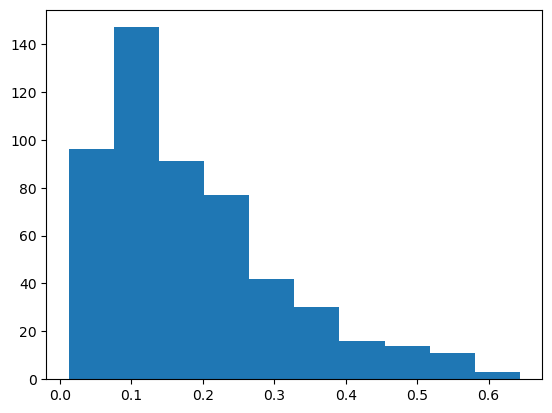

In [200]:
import matplotlib.pyplot as plt
plt.hist(y_val_prediction)

In [170]:

    
    
    _, X_val_transformed = preprocess_data(X_train, X_val, y_train, cat_encoder_strategy='freq')
    
    y_val_prediction = best_model.predict_proba(X_val_transformed)[:,-1]
    return y_val_prediction

KeyError: 'Column(s) [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 132, 133, 135, 136, 137, 138, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 207, 208, 210, 211, 212, 213, 214, 215, 216, 217, 218, 220, 221, 225, 226, 227, 228, 229, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 281, 282, 283, 284, 285, 286, 287, 288, 289, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 364, 365, 366, 367, 368, 369, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 411, 412, 413, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 430, 431, 433, 434, 435, 437, 438, 440, 441, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 497, 498, 499, 501, 502, 503, 505, 506, 507, 508, 509, 510, 511, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 540, 541, 542, 544, 545, 546, 547, 548, 549, 550, 551, 552, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 594, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 663, 664, 665, 666, 667, 668, 669, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 687, 688, 689, 690, 691, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 707, 708, 709, 710, 711, 713, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 726, 727, 728, 729, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 768, 769, 770, 772, 773, 774, 775, 776, 777, 778, 779, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 839, 840, 842, 843, 844, 845, 846, 848, 849, 850, 851, 852, 854, 855, 856, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 870, 871, 872, 873, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 914, 915, 916, 917, 918, 919, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 940, 941, 942, 943, 944, 946, 947, 949, 950, 951, 952, 953, 954, 956, 957, 958, 959, 960, 961, 964, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1050, 1051, 1052, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1067, 1068, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1113, 1114, 1115, 1118, 1119, 1120, 1121, 1122, 1123, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1178, 1179, 1181, 1182, 1183, 1184, 1185, 1186, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1240, 1241, 1242, 1243, 1244, 1245, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1259, 1260, 1261, 1262, 1263, 1267, 1268, 1269, 1271, 1272, 1273, 1274, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1291, 1292, 1293, 1294, 1296, 1297, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1338, 1339, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1402, 1403, 1404, 1405, 1406, 1407, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1420, 1421, 1423, 1424, 1426, 1427, 1429, 1430, 1431, 1432, 1433, 1434, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1498, 1499, 1501, 1502, 1504, 1505, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1531, 1532, 1533, 1535, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1553, 1554, 1555, 1556, 1558, 1559, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1583, 1584, 1586, 1589, 1590, 1591, 1593, 1594, 1596, 1597, 1598, 1599, 1600, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1638, 1639, 1641, 1643, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1658, 1659, 1660, 1661, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1679, 1680, 1681, 1682, 1684, 1686, 1687, 1688, 1689, 1692, 1694, 1695, 1696, 1697, 1698, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1749, 1750, 1751, 1752, 1753, 1754, 1756, 1757, 1758, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1768, 1769, 1770, 1771, 1772, 1773, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1806, 1807, 1809, 1811, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1821, 1822, 1823, 1824, 1825, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1844, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1861, 1862, 1863, 1865, 1866, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1879, 1881, 1883, 1884, 1885, 1886, 1887, 1888, 1890, 1891, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1942, 1943, 1944, 1945, 1946, 1948, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1989, 1991, 1992, 1993, 1994, 1995, 1997, 1998, 1999, 2000, 2001, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2091, 2092, 2093, 2094, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2107, 2108, 2109, 2110, 2111, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2133, 2134, 2135, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2173, 2174, 2175, 2176, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2203, 2204, 2205, 2206, 2207, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2237, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2268, 2269, 2271, 2272, 2273, 2274, 2275, 2276, 2279, 2280, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2291, 2292, 2293, 2294, 2297, 2298, 2299, 2300, 2301, 2303, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2386, 2387, 2388, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2399, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2416, 2417, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2429, 2430, 2431, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2442, 2444, 2445, 2446, 2447, 2448, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2478, 2479, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2489, 2492, 2493, 2494, 2496, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2508, 2509, 2510, 2511, 2512, 2513, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562] do not exist'

In [167]:
X_val = pd.read_csv('../data/raw/data_evaluation.csv')
X_predict = predict_final("../models/freq_114.pickle", X_val)

KeyError: 'Column(s) [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 132, 133, 135, 136, 137, 138, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 207, 208, 210, 211, 212, 213, 214, 215, 216, 217, 218, 220, 221, 225, 226, 227, 228, 229, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 281, 282, 283, 284, 285, 286, 287, 288, 289, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 364, 365, 366, 367, 368, 369, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 411, 412, 413, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 430, 431, 433, 434, 435, 437, 438, 440, 441, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 497, 498, 499, 501, 502, 503, 505, 506, 507, 508, 509, 510, 511, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 540, 541, 542, 544, 545, 546, 547, 548, 549, 550, 551, 552, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 594, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 663, 664, 665, 666, 667, 668, 669, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 687, 688, 689, 690, 691, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 707, 708, 709, 710, 711, 713, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 726, 727, 728, 729, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 768, 769, 770, 772, 773, 774, 775, 776, 777, 778, 779, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 839, 840, 842, 843, 844, 845, 846, 848, 849, 850, 851, 852, 854, 855, 856, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 870, 871, 872, 873, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 914, 915, 916, 917, 918, 919, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 940, 941, 942, 943, 944, 946, 947, 949, 950, 951, 952, 953, 954, 956, 957, 958, 959, 960, 961, 964, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1050, 1051, 1052, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1067, 1068, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1113, 1114, 1115, 1118, 1119, 1120, 1121, 1122, 1123, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1178, 1179, 1181, 1182, 1183, 1184, 1185, 1186, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1240, 1241, 1242, 1243, 1244, 1245, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1259, 1260, 1261, 1262, 1263, 1267, 1268, 1269, 1271, 1272, 1273, 1274, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1291, 1292, 1293, 1294, 1296, 1297, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1338, 1339, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1402, 1403, 1404, 1405, 1406, 1407, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1420, 1421, 1423, 1424, 1426, 1427, 1429, 1430, 1431, 1432, 1433, 1434, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1498, 1499, 1501, 1502, 1504, 1505, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1531, 1532, 1533, 1535, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1553, 1554, 1555, 1556, 1558, 1559, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1583, 1584, 1586, 1589, 1590, 1591, 1593, 1594, 1596, 1597, 1598, 1599, 1600, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1638, 1639, 1641, 1643, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1658, 1659, 1660, 1661, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1679, 1680, 1681, 1682, 1684, 1686, 1687, 1688, 1689, 1692, 1694, 1695, 1696, 1697, 1698, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1749, 1750, 1751, 1752, 1753, 1754, 1756, 1757, 1758, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1768, 1769, 1770, 1771, 1772, 1773, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1806, 1807, 1809, 1811, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1821, 1822, 1823, 1824, 1825, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1844, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1861, 1862, 1863, 1865, 1866, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1879, 1881, 1883, 1884, 1885, 1886, 1887, 1888, 1890, 1891, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1942, 1943, 1944, 1945, 1946, 1948, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1989, 1991, 1992, 1993, 1994, 1995, 1997, 1998, 1999, 2000, 2001, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2091, 2092, 2093, 2094, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2107, 2108, 2109, 2110, 2111, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2133, 2134, 2135, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2173, 2174, 2175, 2176, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2203, 2204, 2205, 2206, 2207, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2237, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2268, 2269, 2271, 2272, 2273, 2274, 2275, 2276, 2279, 2280, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2291, 2292, 2293, 2294, 2297, 2298, 2299, 2300, 2301, 2303, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2386, 2387, 2388, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2399, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2416, 2417, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2429, 2430, 2431, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2442, 2444, 2445, 2446, 2447, 2448, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2478, 2479, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2489, 2492, 2493, 2494, 2496, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2508, 2509, 2510, 2511, 2512, 2513, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562] do not exist'

In [99]:
metricas_modelo(y_test, np.repeat(0, len(y_test)))

 brier: 10.89,
 confusion_m: 
[[229   0]
 [ 28   0]],
 acc_neg: 100.0,
 acc_pos: 0.0,
 accuracy: 89.11


In [97]:
pipeline = Pipeline(steps=steps)
score = cross_val_score(
        pipeline,
        X_train,
        y_train,
        scoring=make_scorer(brier_score_loss, needs_proba=True),
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
)

In [98]:
score

array([0.11277829, 0.10914927, 0.10752955])

Usando metodología  basada en frecuencias